In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import combinations
from scipy.stats import kendalltau, norm
from math import sqrt

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import matplotlib as mpl
plt.style.use('seaborn')
rc('text', usetex=False)
%matplotlib inline

In [3]:
%load_ext autoreload
%aimport models
%autoreload 1
from models import *

In [4]:
legend_opts = {
    'loc':'lower right',
    'fontsize':12,
    'frameon':True, 
    'framealpha':1,
    'facecolor':'white',
    'edgecolor':'black',
    'labelspacing':0.1}

## Import scores from CSV

In [5]:
male_scores = pd.read_csv('scores/trimmed_male.csv')
female_scores = pd.read_csv('scores/trimmed_female.csv')

## Split data into train and test

In [6]:
# Randomly choose 10 years for training set, and remaining 4 years for test set
# (which must include the last year 2018 for visualisation purpose)
years_before_last = range(2005, 2018)
year_seed = np.random.RandomState(seed=42)
train_years = sorted(list(year_seed.choice(years_before_last, size=10, replace=False)))
test_years = sorted([year for year in years_before_last if year not in train_years] + [2018])
train_years, test_years

([2005, 2006, 2007, 2009, 2010, 2012, 2013, 2014, 2016, 2017],
 [2008, 2011, 2015, 2018])

In [7]:
def train_test_split(scores, train_years, test_years):
    ''' Take all scores (for either male and female) 
    and split them into 4 different tables: 
    1. Season scores for training years
    2. World scores for training years
    3. Season scores for testing years
    4. World scores for testing years
    '''
    season_scores = scores.loc[scores['event']!='WR']
    world_scores = scores.loc[scores['event']=='WR']
    
    season_train = season_scores.loc[season_scores['year'].isin(train_years)]
    world_train = world_scores.loc[world_scores['year'].isin(train_years)]
    season_test = season_scores.loc[season_scores['year'].isin(test_years)]
    world_test = world_scores.loc[world_scores['year'].isin(test_years)]    
    
    return season_train, world_train, season_test, world_test

In [8]:
# Create train and test score tables for male skaters
season_train, world_train, season_test, world_test = train_test_split(male_scores, train_years, test_years)
season_train.shape, world_train.shape, season_test.shape, world_test.shape

((1216, 4), (238, 4), (507, 4), (96, 4))

## Implement kendall tau metrics

In [9]:
def return_ranking(skater_scores, world_scores):
    '''
    Return predicted ranking and world rankings (as lists)
    from Series of corresponding scores.
    The reason why both rankings are returned at once is because
    not all skaters in the season will participate in the world championship,
    and vice versa. Therefore, only skaters who participated in both
    will be of interest.    
    '''
    skater_scores = skater_scores.sort_values(ascending=False)
    world_scores = world_scores.sort_values(ascending=False)
    skater_ranking = list(skater_scores.index.intersection(world_scores.index))
    world_ranking = list(world_scores.index.intersection(skater_scores.index))
    return skater_ranking, world_ranking

In [10]:
def calculate_kendall_tau(skater_ranking, world_ranking, verbose=True):
    '''
    Caluculate kendall's tau from two ranking lists of the same size
    '''
    # Generate set of ordered pairs from each ranking
    skater_pairs = set(combinations(skater_ranking, 2))
    world_pairs = set(combinations(world_ranking, 2))
    
    # Calculate number of total, concordant & discordant pairs and tau
    n_pairs = len(skater_pairs)
    n_concordant_pairs = len(skater_pairs & world_pairs)
    
    if verbose:
        print(f'There are {n_concordant_pairs} concordant_pairs out of {n_pairs} pairs')
        
    # Calculate Kendall's tau from pair counts
    tau = (2 * n_concordant_pairs - n_pairs) / n_pairs
    return tau 

Use scores of 2017 for demos

In [11]:
season_scores, world_scores = get_yearly_scores(2017, season_train, world_train)

### Visualize season scores by event

Text(0,1,'FN: Grand Prix Final\nEU: European\n4C: 4 Continent')

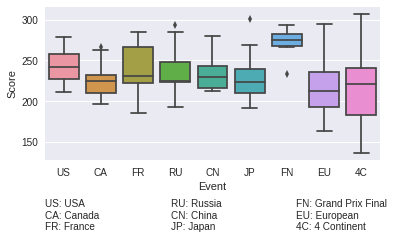

In [12]:
fig = plt.figure()
grid = plt.GridSpec(4, 3, hspace=1.5, wspace=0.5)
ax_box = fig.add_subplot(grid[:-1, :])
ax_box = sns.boxplot(x='event', y='score', data=season_scores, ax=ax_box)
ax_box.set_xlabel('Event')
ax_box.set_ylabel('Score')

ax_label1 = fig.add_subplot(grid[-1, 0])
ax_label2 = fig.add_subplot(grid[-1, 1])
ax_label3 = fig.add_subplot(grid[-1, 2])

for ax in [ax_label1, ax_label2, ax_label3]:
    ax.set_facecolor('white')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
ax_label1.text(0, 1, s='US: USA\nCA: Canada\nFR: France',
               verticalalignment='top',
               transform=ax_label1.transAxes)
ax_label2.text(0, 1, s='RU: Russia\nCN: China\nJP: Japan',
               verticalalignment='top',
               transform=ax_label2.transAxes)
ax_label3.text(0, 1, s='FN: Grand Prix Final\nEU: European\n4C: 4 Continent',
               verticalalignment='top',
               transform=ax_label3.transAxes)
# fig.savefig('viz/2017_score_dist.png')

## Average skate score model

In [13]:
season_avg = season_scores.groupby('name')['score'].mean().sort_values(ascending=False)
season_avg.head()

name
Yuzuru, HANYU        290.5350
Javier, FERNANDEZ    285.4925
Shoma, UNO           283.7425
Nathan, CHEN         281.0050
Patrick, CHAN        270.3500
Name: score, dtype: float64

In [14]:
avg_ranking, world_ranking = return_ranking(season_avg, world_scores)
avg_kendall_tau = calculate_kendall_tau(avg_ranking, world_ranking)
avg_kendall_tau

There are 234 concordant_pairs out of 276 pairs


0.6956521739130435

Result agrees with kendalltau from scipy

In [15]:
season_numeric_rank = list(range(len(avg_ranking)))
world_numeric_rank = [avg_ranking.index(skater) for skater in world_ranking]
kendalltau(season_numeric_rank, world_numeric_rank)

KendalltauResult(correlation=0.6956521739130435, pvalue=1.9126097800691154e-06)

RMSE with mean model

In [16]:
score_comparison = pd.merge(season_scores, season_avg.to_frame(), left_on='name', right_index=True, suffixes=['', '_avg'])
score_comparison['sq_error'] = (score_comparison['score'] - score_comparison['score_avg'])**2
np.sqrt(score_comparison['sq_error'].mean())

10.271546837961868

### Visualize Kendall's tau

In [17]:
def plot_rankings(first_ranking, second_ranking, first_label, second_label, filepath=None):
    ### Take two rankings as sorted list and plot them together
    fig, ax = plt.subplots(figsize=(8, 5))
    cmap = mpl.cm.get_cmap('winter')

    n_skaters = len(first_ranking)
    for index, skater in enumerate(first_ranking):
        first_rank = index + 1
        second_rank = second_ranking.index(skater) + 1

        first_index = n_skaters - first_rank
        second_index = n_skaters - second_rank

        avg_color = cmap(first_rank/(n_skaters*1.1))
        
        # Plot connecting lines between two rankings
        ax.plot([0, 1], [first_index, second_index], 'o-', color=avg_color)
        
        # Plot text on both sides
        ax.text(-0.1, first_index, f'{skater} {first_rank}', ha='right', va='center', color=avg_color)
        ax.text(1.1, second_index, f'{second_rank} {skater}', ha='left', va='center', color=avg_color)

    ax.set_xlim(-1, 2)
    ax.set_xticks([0, 1])
    ax.set_xticklabels([first_label, second_label])
    ax.set_yticks([])
    plt.tight_layout()
    plt.show()
    if filepath:
        fig.savefig(filepath)

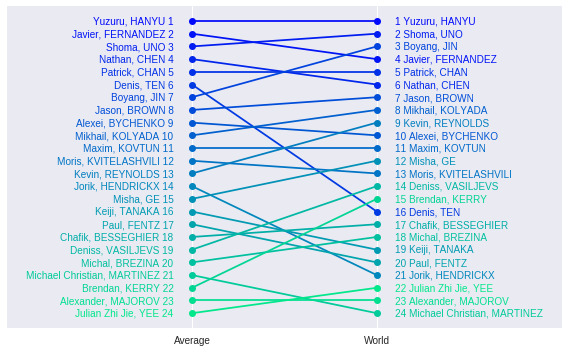

In [18]:
plot_rankings(avg_ranking, world_ranking, 'Average', 'World')

## Normalized mean model

In [22]:
season_scores['score_normed'] = season_scores.groupby('event')['score'].transform(lambda score: (score - score.mean()) / score.std())

In [23]:
season_normed_avg = season_scores.groupby('name')['score_normed'].mean().sort_values(ascending=False)
season_normed_avg.head()

name
Yuzuru, HANYU        1.668135
Javier, FERNANDEZ    1.440927
Shoma, UNO           1.326910
Nathan, CHEN         1.104096
Patrick, CHAN        1.090843
Name: score_normed, dtype: float64

In [24]:
normed_avg_ranking, world_ranking = return_ranking(season_normed_avg, world_scores)
calculate_kendall_tau(normed_avg_ranking, world_ranking)

There are 222 concordant_pairs out of 276 pairs


0.6086956521739131

## Linear model

In [30]:
year = 2017
season_scores = season_train.loc[season_train['year']==year].copy()
world_scores = world_train.loc[world_train['year']==year, ['name', 'score']].set_index('name').squeeze()

In [31]:
dummies = pd.get_dummies(season_scores[['name', 'event']], prefix=['', ''], prefix_sep='', drop_first=True)
unique_skaters = season_scores['name'].unique()
unique_events = season_scores['event'].unique()

dummies_skater_count = len(unique_skaters) - 1
dummies_skaters = dummies.columns[:dummies_skater_count]
dummies_events = dummies.columns[dummies_skater_count:]

dropped_skater = list(set(unique_skaters) - set(dummies_skaters))[0]
dropped_event = list(set(unique_events) - set(dummies_events))[0]

Choose random skaters to save as CSV file to display in blog post

In [32]:
random_scores = season_scores.sample(n=5, random_state=42)
random_scores.to_csv('random_scores_linear.csv')

In [33]:
random_dummies = dummies.loc[:, dummies_skaters[[0, 1, -2, -1]].append(dummies_events)]
random_dummies = random_dummies.loc[(random_dummies.iloc[:, :4] != 0).any(axis=1)]
random_dummies.join(season_scores['score']).to_csv('random_dummies.csv')

### Apply normal equation

In [310]:
# Create numpy feature matrix and response vector
X = dummies.values
y = season_scores['score'].values

# Append column of all 1's to the left of feature matrix
X = np.insert(X, obj=0, values=1, axis=1)

# Apply normal equation to find linear regression coefficients (including intercept)
coefs_linear = np.linalg.inv(X.T @ X) @ (X.T @ y)
coefs_linear[:10]

array([ 262.83064921,  -58.77196129,  -27.74060019,  -38.56497213,
        -16.6525816 , -100.78064921,  -36.58476179,    3.9048582 ,
        -45.88750626,  -35.41149857])

In [35]:
linear_rmse = np.sqrt(np.mean((y - X @ coefs_linear)**2))
linear_rmse

8.838699611397724

Double check with sklearn's LinearRegression and mean_square_error

In [36]:
lin = LinearRegression(fit_intercept=False)
lin.fit(X, y)
lin.coef_[:10], lin.intercept_

(array([ 262.83064921,  -58.77196129,  -27.74060019,  -38.56497213,
         -16.6525816 , -100.78064921,  -36.58476179,    3.9048582 ,
         -45.88750626,  -35.41149857]), 0.0)

In [37]:
np.sqrt(mean_squared_error(y, X @ lin.coef_))

8.838699611397724

Add dropped baseline skater and event

In [38]:
# Extract baseline, skater, and event scores from regression coefficients
baseline_score = coefs_linear[0]
skater_scores = pd.Series(coefs_linear[1:dummies_skater_count+1], index=dummies_skaters)
event_scores = pd.Series(coefs_linear[dummies_skater_count+1:], index=dummies_events)

# Add back scores of dropped skater and dropped event
skater_scores[dropped_skater] = 0
event_scores[dropped_event] = 0

# Sort skater scores and event scores from highest to lowest
skater_scores.sort_values(ascending=False, inplace=True)
event_scores.sort_values(ascending=False, inplace=True)

In [39]:
baseline_score

262.83064920747165

In [40]:
event_scores

EU     6.604323
4C     0.000000
CN    -4.467169
RU    -4.601699
US    -4.609353
FR    -7.670076
CA   -12.882929
FN   -14.152519
JP   -15.906827
dtype: float64

In [41]:
skater_scores

Yuzuru, HANYU                   38.439919
Javier, FERNANDEZ               27.616843
Nathan, CHEN                    27.606706
Shoma, UNO                      26.752743
Patrick, CHAN                   15.395005
Denis, TEN                      14.099427
Boyang, JIN                      3.904858
Adam, RIPPON                     0.000000
Jason, BROWN                   -11.758589
Sergei, VORONOV                -13.772388
Alexei, BYCHENKO               -16.652582
Takahito, MURA                 -17.279147
Mikhail, KOLYADA               -17.805915
Max, AARON                     -19.136215
Maxim, KOVTUN                  -22.346583
Kevin, REYNOLDS                -22.704185
Misha, GE                      -24.466314
Keiji, TANAKA                  -24.817807
Nam, NGUYEN                    -26.401923
Alexander, PETROV              -27.740600
Jorik, HENDRICKX               -28.292281
Moris, KVITELASHVILI           -31.234972
Timothy, DOLENSKY              -31.691296
Han, YAN                       -32

In [42]:
linear_ranking, world_ranking = return_ranking(skater_scores, world_scores)

In [43]:
calculate_kendall_tau(linear_ranking, world_ranking)

There are 239 concordant_pairs out of 276 pairs


0.7318840579710145

### Visualisations

Export skater scores (those who qualified for worlds) for visualisation

In [44]:
skater_scores.loc[linear_ranking].to_csv('viz/skater_scores_additive_2017.csv')

Plot bar chart of predicted scores for all season scores

In [46]:
df_compare_add = pd.merge(season_scores, event_scores.to_frame(name='event_score'), how='left', left_on='event', right_index=True)
df_compare_add = pd.merge(df_compare_add, skater_scores.to_frame(name='skater_score'), how='left', left_on='name', right_index=True)
df_compare_add = pd.merge(df_compare_add, season_avg.to_frame(name='avg'), left_on='name', how='left', right_index=True)
df_compare_add['baseline'] = baseline_score
df_compare_add['baseline_event'] = df_compare_add['baseline'] + df_compare_add['event_score']
df_compare_add['predicted'] = df_compare_add['baseline'] + df_compare_add['event_score'] + df_compare_add['skater_score']
df_compare_add['residual'] = df_compare_add['predicted'] - df_compare_add['score']
df_compare_add

,name,year,event,score,event_score,skater_score,avg,baseline,baseline_event,predicted,residual
1743,"Shoma, UNO",2017,US,279.34,-4.609353,26.752743,283.742500,262.830649,258.221296,284.974040,5.634040e+00
1744,"Jason, BROWN",2017,US,268.38,-4.609353,-11.758589,244.233333,262.830649,258.221296,246.462707,-2.191729e+01
1745,"Adam, RIPPON",2017,US,261.43,-4.609353,0.000000,254.020000,262.830649,258.221296,258.221296,-3.208704e+00
1746,"Sergei, VORONOV",2017,US,245.28,-4.609353,-13.772388,244.520000,262.830649,258.221296,244.448908,-8.310916e-01
1747,"Boyang, JIN",2017,US,245.08,-4.609353,3.904858,263.710000,262.830649,258.221296,262.126155,1.704615e+01
1748,"Nam, NGUYEN",2017,US,239.26,-4.609353,-26.401923,229.590000,262.830649,258.221296,231.819374,-7.440626e+00
1749,"Maxim, KOVTUN",2017,US,230.75,-4.609353,-22.346583,239.660000,262.830649,258.221296,235.874714,5.124714e+00
1750,"Timothy, DOLENSKY",2017,US,226.53,-4.609353,-31.691296,226.530000,262.830649,258.221296,226.530000,-3.666401e-12
1751,"Jorik, HENDRICKX",2017,US,224.91,-4.609353,-28.292281,232.646667,262.830649,258.221296,229.929016,5.019016e+00
1752,"Brendan, KERRY",2017,US,211.76,-4.609353,-45.887506,212.850000,262.830649,258.221296,212.333790,5.737902e-01


In [47]:
def plot_scores(df_compare, filename=None,
                labels=['Baseline', 'Baseline + Event', 'Baseline + Event + Skater (predicted)'],):
    fig, ax = plt.subplots(figsize=(15, 5))
    x_coords = np.arange(len(df_compare))

    ax.scatter(x_coords, df_compare['baseline'], color='tab:green', marker='_', label=labels[0], zorder=0)
    ax.scatter(x_coords, df_compare['baseline_event'], color='tab:blue', marker='_', label=labels[1], zorder=1)
    ax.bar(x_coords+0.06, df_compare['score']-df_compare['predicted'], bottom=df_compare['predicted'],
           align='center', color='black', alpha=0.1, zorder=2)
    ax.scatter(x_coords, df_compare['predicted'], color='tab:orange', marker='_', label=labels[2], zorder=3)
    ax.scatter(x_coords, df_compare['score'], color='tab:red', marker='_', label='True',zorder=4)

    ax.axvline(-0.5, color='white', zorder=0)
    ax.grid(axis='x')
    events = df_compare['event'].drop_duplicates()
    event_counts = df_compare['event'].value_counts().loc[events]
    for count in event_counts.cumsum():
        ax.axvline(count-0.5, color='white', zorder=0)
    ax.set_xticks(event_counts.cumsum() - event_counts/2 - 0.5)
    ax.set_xticklabels(events)

    ax.set_xlim([-0.5, len(x_coords)-0.5])
    ax.set_ylim([100, 350])
    ax.set_xlabel('Event', fontsize=15)
    ax.set_ylabel('Season score', fontsize=15)

    ax.legend(loc='lower left', fontsize=12, frameon=True, framealpha=1, facecolor='white', edgecolor='black', labelspacing=0.1)
    plt.tight_layout()
    plt.show()
    
    if filename:
        fig.savefig(filename)

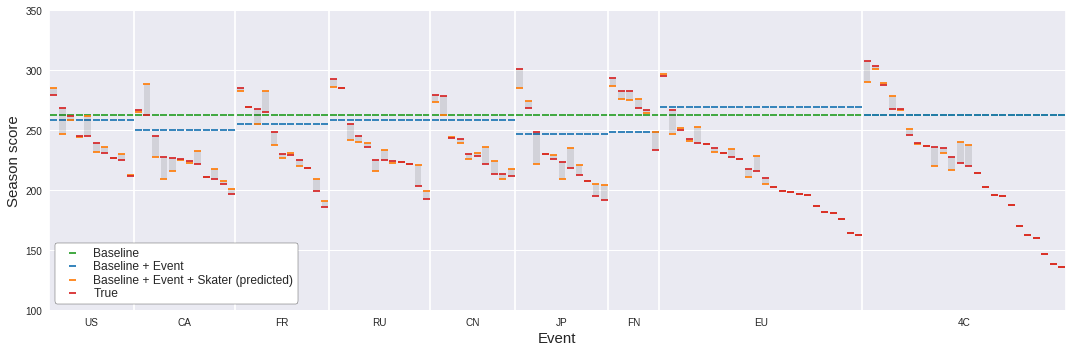

In [48]:
plot_scores(df_compare_add)

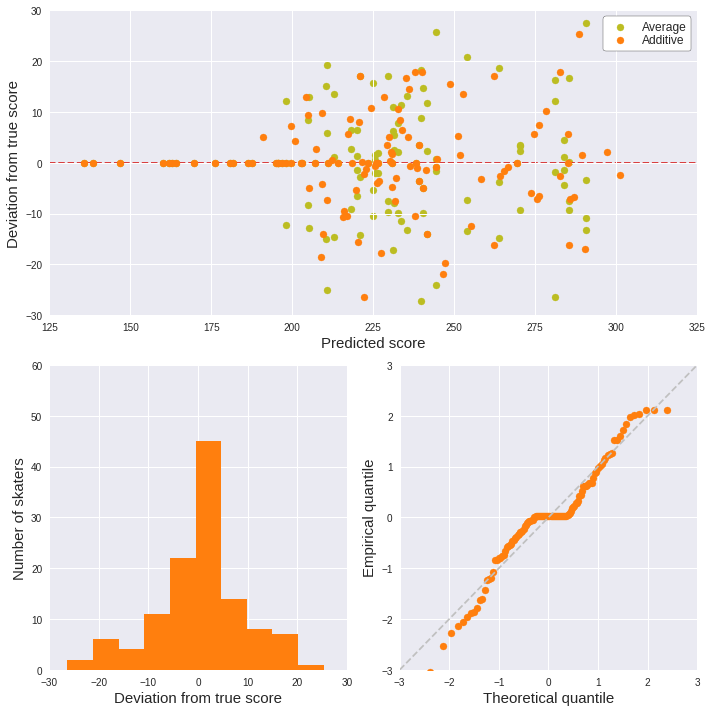

In [305]:
fig = plt.figure(figsize=(10, 10))
grid = plt.GridSpec(2, 2)

ax = fig.add_subplot(grid[0, :])
ax.axhline(0, color='tab:red', zorder=0, ls='--')
ax.scatter(df_compare_add['avg'], df_compare_add['avg']-df_compare_add['score'], color='tab:olive', label='Average', zorder=0)
ax.scatter(df_compare_add['predicted'], df_compare_add['predicted']-df_compare_add['score'], color='tab:orange', label='Additive', zorder=1)

ax.set_xlabel('Predicted score', fontsize=15)
ax.set_ylabel('Deviation from true score', fontsize=15)

ax.set_xlim([125, 325])
ax.set_ylim([-30, 30])
ax.legend(fontsize=12, frameon=True, framealpha=1, facecolor='white', edgecolor='black', labelspacing=0.1)

ax1 = fig.add_subplot(grid[1, 0])
residuals = (df_compare_add['predicted'] - df_compare_add['score']).values
ax1.hist(residuals, color='tab:orange')
ax1.set_xlim(-30, 30)
ax1.set_xlabel('Deviation from true score', fontsize=15)
ax1.set_ylim(0, 60)
ax1.set_ylabel('Number of skaters', fontsize=15)

ax2 = fig.add_subplot(grid[1, 1])
cum_probs = np.arange(1, len(residuals)) / len(residuals) 
percentiles = norm().ppf(cum_probs)
sorted_residuals = np.sort(residuals)[:-1]
normalized_residual = (sorted_residuals - sorted_residuals.mean()) / sorted_residuals.std()

ax2.scatter(percentiles, normalized_residual, color='tab:orange')
ax2.plot([-3, 3], [-3, 3], '--', color='silver')
ax2.set_xlabel('Theoretical quantile', fontsize=15)
ax2.set_ylabel('Empirical quantile', fontsize=15)
ax2.set_xlim([-3, 3])
ax2.set_ylim([-3, 3])

plt.tight_layout()

fig.savefig('viz/additive_model_check.png')

Check skaters with zero residuals

In [50]:
skaters_with_small_residual = set(df_compare_add.loc[(df_compare_add['predicted'] - df_compare_add['score']).abs() < 0.001, 'name'])
skaters_with_small_residual

{'Alexander, SAMARIN',
 'Andrew, DODDS',
 'Chih-I, TSAO',
 'Daniel Albert, NAURITS',
 'Denis, TEN',
 'Gordei, GORSHKOV',
 'Graham, NEWBERRY',
 'Ivan, PAVLOV',
 'Javier, RAYA',
 'Jinseo, KIM',
 'Jiri, BELOHRADSKY',
 'Julian Zhi Jie, YEE',
 'June Hyoung, LEE',
 'Kai Xiang, CHEW',
 'Kevin, AYMOZ',
 'Leslie, IP',
 'Liam, FIRUS',
 'Mark, WEBSTER',
 'Maurizio, ZANDRON',
 'Micah, TANG',
 'Michael Christian, MARTINEZ',
 'Moris, KVITELASHVILI',
 'Paul, FENTZ',
 'Ryuju, HINO',
 'Sihyeong, LEE',
 'Slavik, HAYRAPETYAN',
 'Sondre, ODDVOLL BOE',
 'Stephane, WALKER',
 'Timothy, DOLENSKY',
 'Valtter, VIRTANEN'}

In [51]:
event_counts_per_skater = df_compare_add['name'].value_counts()
skaters_with_one_event = set(event_counts_per_skater[event_counts_per_skater == 1].index)

In [54]:
skaters_with_small_residual - skaters_with_one_event, skaters_with_one_event - skaters_with_small_residual

(set(), set())

Plot comparison with world ranking

In [55]:
def plot_multiple_rankings(ax, rankings, labels, filepath=None, xfontsize=None, zorder=None):
    ### Take two rankings as sorted list and plot them together
    
    cmap = mpl.cm.get_cmap('winter')

    first_ranking = rankings[0]
#     last_ranking = ranking[-1]
    
    n_skaters = len(first_ranking)
    for index, skater in enumerate(first_ranking):
        first_rank = index + 1
        first_index = n_skaters - first_rank
        avg_color = cmap(first_rank/(n_skaters*1.1))
        
        indicies = []
        indicies.append(first_index)
        for ranking in rankings[1:]:        
            subsequent_rank = ranking.index(skater) + 1
            subsequent_index = n_skaters - subsequent_rank
            indicies.append(subsequent_index)

        # Plot connecting lines between two rankings
        ax.plot(np.arange(len(rankings)), indicies,
                'o-', color=avg_color, zorder=zorder)

        # Plot text on both sides
        ax.text(-0.1, first_index, f'{skater} {first_rank}', ha='right', va='center', color=avg_color)
        ax.text(len(rankings)-0.9, subsequent_index, f'{subsequent_rank} {skater}', ha='left', va='center', color=avg_color)
        

    ax.set_xlim(-1, len(rankings))
    ax.set_xticks(np.arange(len(rankings)))
    ax.set_xticklabels(labels, fontsize=xfontsize)
    ax.set_yticks([])
    plt.tight_layout()
    
    if filepath:
        fig.savefig(filepath)

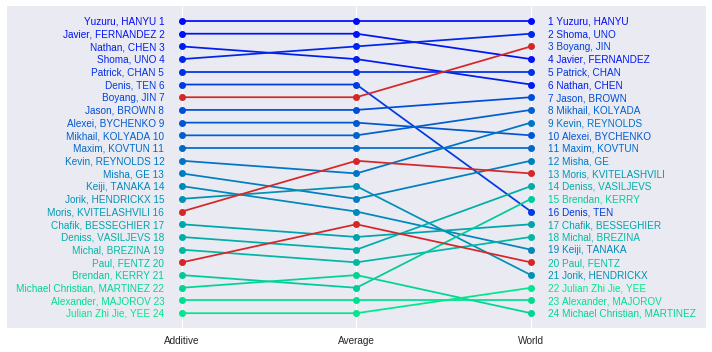

In [292]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_multiple_rankings(ax, [linear_ranking, avg_ranking, world_ranking], ['Additive', 'Average', 'World'])
for line_id in [19, 15, 6]:
    del ax.lines[line_id]
ax.plot(range(3), [4, 7, 4], 'o-', color='tab:red')
ax.plot(range(3), [8, 12, 11], 'o-', color='tab:red')
ax.plot(range(3), [17, 17, 21], 'o-', color='tab:red')
fig.savefig('viz/board:add_avg_world.png')

Visualize

In [76]:
lambda_values = [0, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

In [77]:
df_skater_lambda = pd.DataFrame()
df_event_lambda = pd.DataFrame()
df_baseline_lambda = []
rankings_lambda = []
concords_lambda = []
taus_lambda = []
rmses_lambda = []

for lambda_reg in lambda_values:
    linear = Linear(lambda_reg=lambda_reg)
    linear.fit(season_scores)
    df_baseline_lambda.append(linear.baseline)
    df_skater_lambda[str(lambda_reg)] = linear.skater_scores
    df_event_lambda[str(lambda_reg)] = linear.event_scores
    
    concords_lambda.append(linear.evaluate_kendall_tau(world_scores, verbose=False)[1])
    taus_lambda.append(linear.evaluate_kendall_tau(world_scores, verbose=False)[0])
    rankings_lambda.append(linear.return_ranking(world_scores)[0])
    rmses_lambda.append(round(linear.evaluate_rmse(season_scores), 1))
    
df_skater_lambda = df_skater_lambda.loc[world_scores.index]
df_event_lambda = df_event_lambda.loc[dummies_events]

In [78]:
from matplotlib.patches import ConnectionPatch

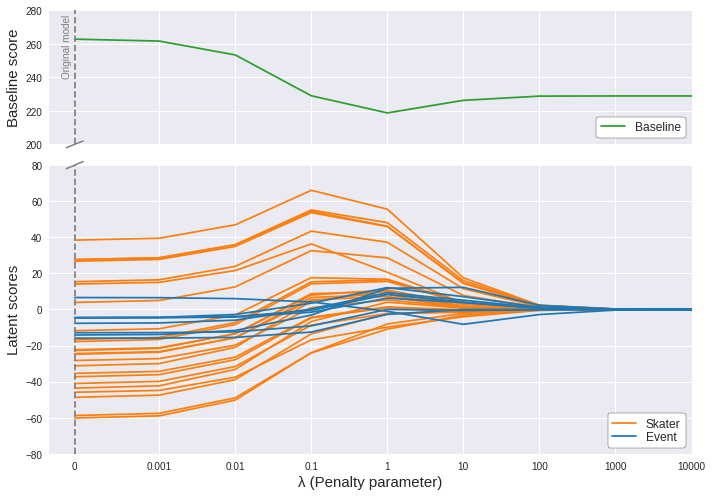

In [79]:
fig = plt.figure(figsize=(10, 7))
grid = plt.GridSpec(3, 1)
ax = fig.add_subplot(grid[1:, :])
axb = fig.add_subplot(grid[0, :])

axb.plot(lambda_values, df_baseline_lambda, color='tab:green', label='Baseline')
axb.axvline(0, ls='--', color='tab:gray')
axb.text(-0.00015, 278, s='Original model', verticalalignment='top', rotation=90, fontsize=10, color='tab:gray')
axb.plot((-0.0001, 0.0001), (198, 202), color='tab:gray', lw=1.5, transform=axb.transData, clip_on=False)

axb.set_xscale('symlog', linthreshx=0.001)
axb.set_xlim(-0.0003, 10000)
axb.get_xaxis().set_ticklabels([])
axb.set_ylim(200, 280)
axb.set_yticks(np.arange(200, 281, 20))
axb.set_ylabel('Baseline score', fontsize=15)
axb.legend(**legend_opts)
  
for i, row in df_skater_lambda.iterrows():
    if i == 'Yuzuru, HANYU':
        ax.plot(lambda_values, row.values, color='tab:orange', label='Skater')
    else:
        ax.plot(lambda_values, row.values, color='tab:orange')
        
        
for i, row in df_event_lambda.iterrows():
    if i == 'CA':
        ax.plot(lambda_values, row.values, color='tab:blue', label='Event')
    else:
        ax.plot(lambda_values, row.values, color='tab:blue')        

ax.axvline(0, ls='--', color='tab:gray')
ax.plot((-0.0001, 0.0001), (78, 82), color='tab:gray', lw=1.5, transform=ax.transData, clip_on=False)
ax.legend(**legend_opts)

ax.set_xscale('symlog', linthreshx=0.001)
ax.set_xlim(-0.0003, 10000)
ax.set_xlabel('λ (Penalty parameter)', fontsize=15)
ax.set_xticklabels(lambda_values)

ax.set_ylabel('Latent scores', fontsize=15)
ax.set_ylim(-80, 80)
plt.tight_layout()
plt.show()

fig.savefig('viz/lambda_linear_coeffs.png')

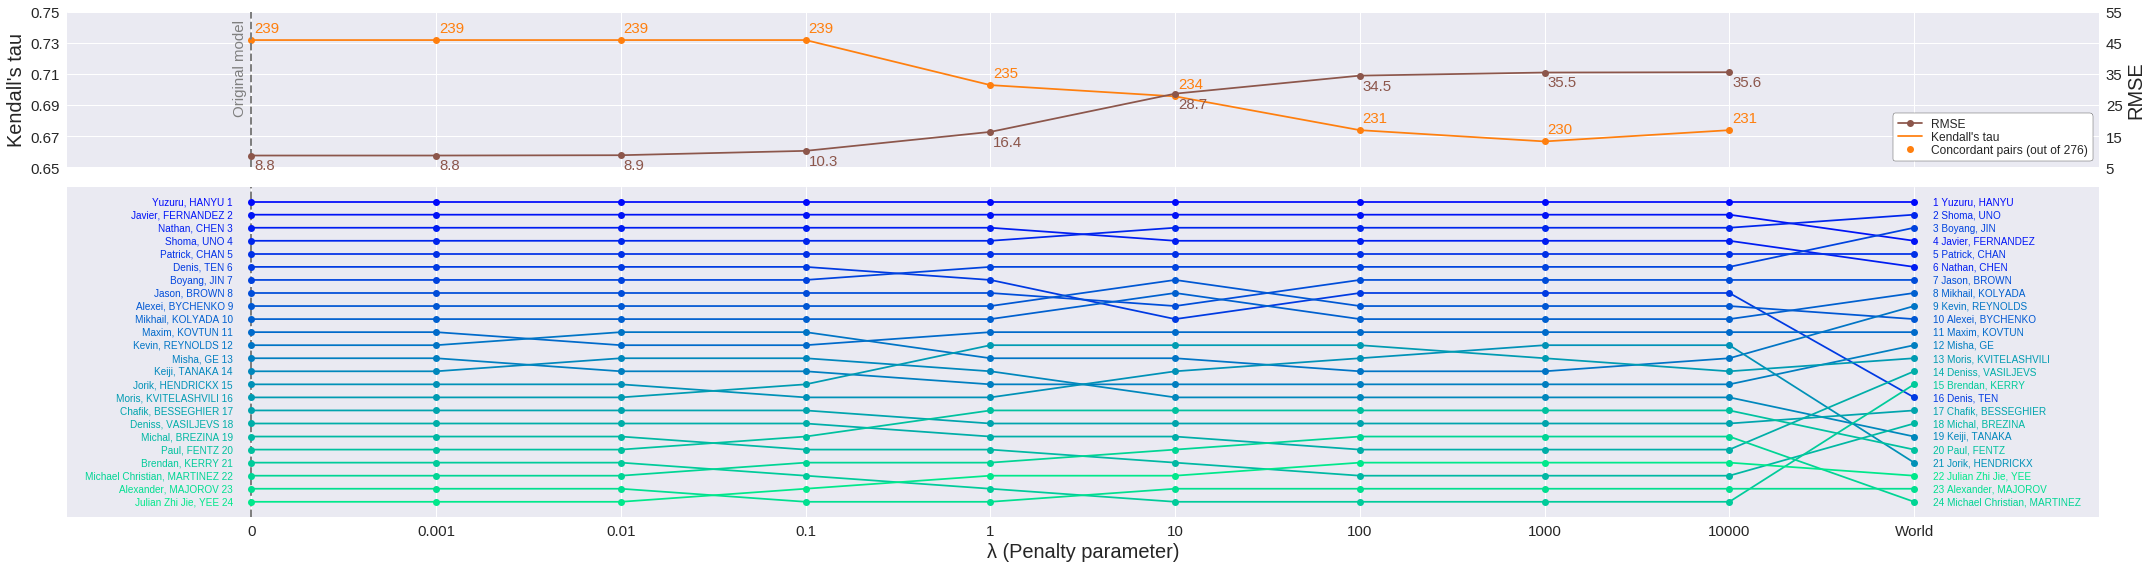

In [80]:
fig = plt.figure(figsize=(30, 8))
grid = plt.GridSpec(3, 1)
ax2 = fig.add_subplot(grid[1:, :])
ax1 = fig.add_subplot(grid[0, :], sharex=ax2)

l1 = ax1.plot(taus_lambda, 'o', color='tab:orange', label='Concordant pairs (out of 276)')
l2 = ax1.plot(taus_lambda, color='tab:orange', zorder=10, label="Kendall's tau")
ax1.axvline(0, ls='--', lw=2, color='tab:gray')
ax1.text(-0.10, 0.745, s='Original model', verticalalignment='top', rotation=90, fontsize=15, color='tab:gray')

for i, (tau, concord) in enumerate(zip(taus_lambda, concords_lambda)):
    ax1.text(i + 0.015, tau + 0.005, s=concord, color='tab:orange', fontsize=15)

ax1.set_ylim(0.65, 0.75)
ax1.set_yticks(np.arange(0.65, 0.76, 0.02))
ax1.tick_params(labelsize=15)
ax1.set_ylabel("Kendall's tau", fontsize=20)

axt = ax1.twinx()
l3 = axt.plot(rmses_lambda, '-o', color='tab:brown', label='RMSE')

lns = l3 + l2 + l1
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, **legend_opts)

for i, rmse in enumerate(rmses_lambda):
    axt.text(i + 0.015, rmse - 1, verticalalignment='top', s=rmse, color='tab:brown', fontsize=15)

axt.set_ylim(5, 55)
axt.set_yticks(np.arange(5, 56, 10))
axt.tick_params(labelsize=15)
axt.set_ylabel('RMSE', fontsize=20)
axt.grid(False)

plot_multiple_rankings(ax2, rankings_lambda+[world_ranking], lambda_values+['World'], 
#                        'viz/linear_lambda_ranking.png',
                       xfontsize=15, zorder=10)
ax2.axvline(0, ls='--', lw=2, color='tab:gray')
ax2.set_xlabel('λ (Penalty parameter)', fontsize=20)

plt.setp(ax1.get_xticklabels(), visible=False)
plt.tight_layout()
plt.show()
fig.savefig('viz/linear_lambda_ranking.png')

## Log-linear Model

In [83]:
coefs_log_linear = np.linalg.inv(X.T @ X) @ (X.T @ np.log(y))
coefs_log_linear[:10]

array([ 5.57079276, -0.2537603 , -0.11337176, -0.15854428, -0.06450661,
       -0.48288783, -0.14988655,  0.01455732, -0.19499875, -0.14436472])

In [84]:
log_linear_rmse = np.sqrt(np.mean((y - np.exp(X @ coefs_log_linear))**2))
log_linear_rmse

8.881273109759167

In [85]:
baseline_score = coefs_log_linear[0]
skater_scores = pd.Series(coefs_log_linear[1:dummies_skater_count+1], index=dummies_skaters)
event_scores = pd.Series(coefs_log_linear[dummies_skater_count+1:], index=dummies_events)

skater_scores[dropped_skater] = 0
event_scores[dropped_event] = 0

skater_scores.sort_values(ascending=False, inplace=True)
event_scores.sort_values(ascending=False, inplace=True)

baseline_score = np.exp(baseline_score)
skater_scores = np.exp(skater_scores)
event_scores = np.exp(event_scores)

In [86]:
baseline_score

262.64223001202095

Double check with sklearn's LinearRegression and mean_square_error

In [87]:
lin = LinearRegression(fit_intercept=False)
lin.fit(X, np.log(y))
lin.coef_[:10], lin.intercept_

(array([ 5.57079276, -0.2537603 , -0.11337176, -0.15854428, -0.06450661,
        -0.48288783, -0.14988655,  0.01455732, -0.19499875, -0.14436472]), 0.0)

In [88]:
(np.exp(X @ coefs_log_linear) - y).std(ddof=0)

8.879812812757304

Evaluate Kendall's Tau

In [89]:
log_linear_ranking, world_ranking = return_ranking(skater_scores, world_scores)

In [90]:
calculate_kendall_tau(linear_ranking, world_ranking)

There are 239 concordant_pairs out of 276 pairs


0.7318840579710145

Visualise

In [91]:
skater_scores.loc[log_linear_ranking].to_csv('viz/multiplicative_skater_scores.csv')

In [92]:
df_compare_mul = pd.merge(season_scores, event_scores.to_frame(name='event_score'), how='left', left_on='event', right_index=True)
df_compare_mul = pd.merge(df_compare_mul, skater_scores.to_frame(name='skater_score'), how='left', left_on='name', right_index=True)
df_compare_mul = pd.merge(df_compare_mul, season_avg.to_frame(name='avg'), left_on='name', how='left', right_index=True)
df_compare_mul['baseline'] = baseline_score
df_compare_mul['baseline_event'] = df_compare_mul['baseline'] * df_compare_mul['event_score']
df_compare_mul['predicted'] = df_compare_mul['baseline'] * df_compare_mul['event_score'] * df_compare_mul['skater_score']
df_compare_mul['residual'] = df_compare_mul['predicted'] - df_compare_mul['score']
df_compare_mul

,name,year,event,score,event_score,skater_score,avg,baseline,baseline_event,predicted,residual
1743,"Shoma, UNO",2017,US,279.34,0.982756,1.105957,283.742500,262.64223,258.113317,285.462120,6.122120e+00
1744,"Jason, BROWN",2017,US,268.38,0.982756,0.953747,244.233333,262.64223,258.113317,246.174780,-2.220522e+01
1745,"Adam, RIPPON",2017,US,261.43,0.982756,1.000000,254.020000,262.64223,258.113317,258.113317,-3.316683e+00
1746,"Sergei, VORONOV",2017,US,245.28,0.982756,0.947786,244.520000,262.64223,258.113317,244.636073,-6.439272e-01
1747,"Boyang, JIN",2017,US,245.08,0.982756,1.014664,263.710000,262.64223,258.113317,261.898239,1.681824e+01
1748,"Nam, NGUYEN",2017,US,239.26,0.982756,0.898441,229.590000,262.64223,258.113317,231.899488,-7.360512e+00
1749,"Maxim, KOVTUN",2017,US,230.75,0.982756,0.911407,239.660000,262.64223,258.113317,235.246302,4.496302e+00
1750,"Timothy, DOLENSKY",2017,US,226.53,0.982756,0.877638,226.530000,262.64223,258.113317,226.530000,1.415401e-11
1751,"Jorik, HENDRICKX",2017,US,224.91,0.982756,0.891376,232.646667,262.64223,258.113317,230.076124,5.166124e+00
1752,"Brendan, KERRY",2017,US,211.76,0.982756,0.822836,212.850000,262.64223,258.113317,212.384849,6.248494e-01


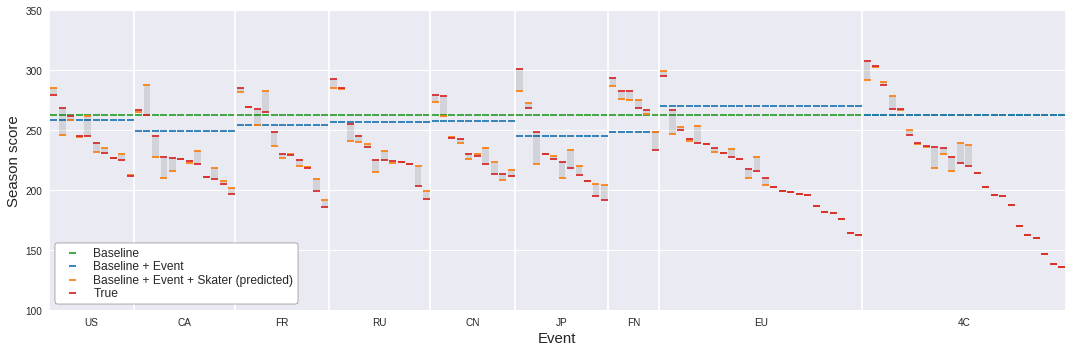

In [93]:
plot_scores(df_compare_mul)

In [94]:
avg_residual = (df_compare_mul['avg']-df_compare_mul['score']).values
add_residual = df_compare_add['residual'].values
mul_residual = df_compare_mul['residual'].values

In [95]:
heights = []
for residual_triple in zip(avg_residual, add_residual, mul_residual):
    max_residual, min_residual = max(residual_triple), min(residual_triple)
    if abs(max_residual) > abs(min_residual):
        height = max_residual
    else:
        height = min_residual
    heights.append(height)

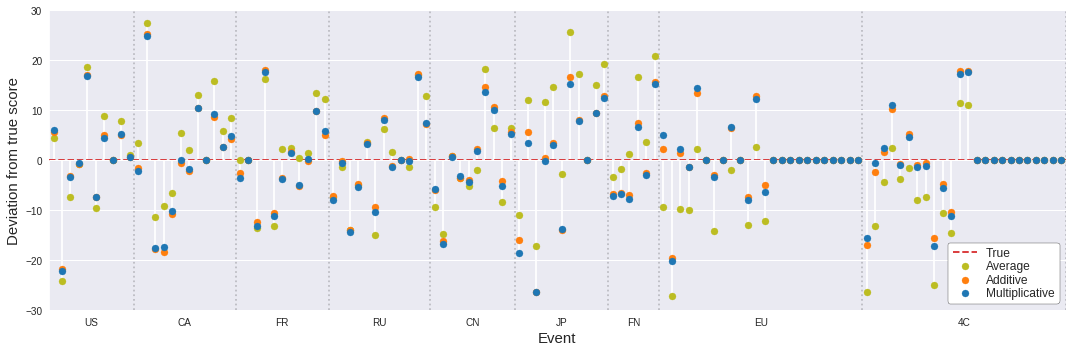

In [96]:
fig, ax = plt.subplots(figsize=(15, 5))

x_coords = np.arange(len(df_compare_mul))
ax.scatter(x_coords, df_compare_mul['avg']-df_compare_mul['score'], color='tab:olive', label='Average', zorder=1)
ax.scatter(x_coords, df_compare_add['predicted']-df_compare_add['score'], color='tab:orange', label='Additive', zorder=2)
ax.scatter(x_coords, df_compare_mul['predicted']-df_compare_mul['score'], color='tab:blue', label='Multiplicative', zorder=3)
ax.vlines(x=x_coords, ymin=[0]*len(heights), ymax=heights, color='white', zorder=0)

ax.set_xlabel('True score', fontsize=15)
ax.set_ylabel('Deviation from true score', fontsize=15)

ax.grid(axis='x')
events = df_compare_mul['event'].drop_duplicates()
event_counts = df_compare_mul['event'].value_counts().loc[events]
for count in event_counts.cumsum():
    ax.axvline(count-0.5, color='black', alpha=0.2, ls='dotted', zorder=0)
ax.set_xticks(event_counts.cumsum() - event_counts/2 - 0.5)
ax.set_xticklabels(events)

ax.axvline(-0.5, color='white', zorder=0)
ax.set_xlim([-0.5, len(x_coords)-0.5])
ax.set_ylim([-30, 30])
ax.set_xlabel('Event', fontsize=15)
ax.set_ylabel('Deviation from true score', fontsize=15)

ax.axhline(0, color='tab:red', zorder=0, ls='--', label='True')

ax.legend(loc='lower right', fontsize=12, frameon=True, framealpha=1, facecolor='white', edgecolor='black', labelspacing=0.1)

plt.tight_layout()
plt.show()

fig.savefig('viz/avg_add_mul.png')

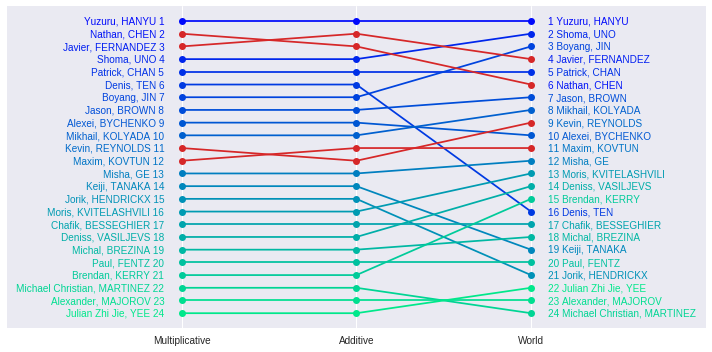

In [296]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_multiple_rankings(ax, [log_linear_ranking, linear_ranking, world_ranking],
              ['Multiplicative', 'Additive', 'World'])
for line_id in [11, 10, 2, 1]:
    del ax.lines[line_id]
ax.plot(range(3), [12, 13, 13], 'o-', color='tab:red')
ax.plot(range(3), [13, 12, 15], 'o-', color='tab:red')
ax.plot(range(3), [21, 22, 20], 'o-', color='tab:red')
ax.plot(range(3), [22, 21, 18], 'o-', color='tab:red')
fig.savefig('viz/board: mul_add_world.png')

### Refactor

2017

All 10 years in training set

In [150]:
linear = Linear(lambda_reg=0)
linear_train_eval = linear.evaluate_over_years(train_years, season_train, world_train)
linear_train_eval

,year,rmse,tau,conc,pairs
0,2005,8.555327,0.666667,175,210
1,2006,7.883763,0.620553,205,253
2,2007,7.578146,0.601449,221,276
3,2009,8.110917,0.586957,219,276
4,2010,9.798364,0.696970,196,231
5,2012,8.144647,0.541502,195,253
6,2013,9.047367,0.691700,214,253
7,2014,8.781486,0.809524,190,210
8,2016,11.053367,0.673913,231,276
9,2017,8.838700,0.731884,239,276


In [229]:
linear_lambda_df = []
for lambda_reg in lambda_values:
    linear = Linear(lambda_reg=lambda_reg)
    linear_train_eval = linear.evaluate_over_years(train_years, season_train, world_train)
    rmse_diff = linear_train_eval['rmse'] - avg_train_eval['rmse']
    tau_diff = linear_train_eval['tau'] - avg_train_eval['tau']
    linear_lambda_df.append({'lambda': lambda_reg,
                            'rmse_diff_avg': rmse_diff.mean(),
                            'rmse_diff_std': rmse_diff.std(),
                            'tau_diff_avg': tau_diff.mean(),
                            'tau_diff_std': tau_diff.std()})
linear_lambda_df = pd.DataFrame(linear_lambda_df)

In [230]:
linear_lambda_df

,lambda,rmse_diff_avg,rmse_diff_std,tau_diff_avg,tau_diff_std
0,0.000,-1.308318,0.510017,-0.008421,0.046550
1,0.001,-1.304771,0.511041,-0.008583,0.044896
2,0.010,-1.162353,0.571810,-0.010843,0.046240
3,0.100,-0.299386,0.903855,-0.016734,0.046234
4,1.000,5.118508,1.387144,-0.033202,0.039853
5,10.000,16.955319,2.096823,-0.051225,0.049136
6,100.000,22.260621,2.267867,-0.045475,0.044208
7,1000.000,23.163882,2.295367,-0.043742,0.046239
8,10000.000,23.263993,2.298858,-0.043083,0.045633


In [235]:
log_linear_lambda_df = []
for lambda_reg in lambda_values:
    log_linear = LogLinear(lambda_reg=lambda_reg)
    log_linear_train_eval = log_linear.evaluate_over_years(train_years, season_train, world_train)
    rmse_diff = log_linear_train_eval['rmse'] - avg_train_eval['rmse']
    tau_diff = log_linear_train_eval['tau'] - avg_train_eval['tau']
    log_linear_lambda_df.append({'lambda': lambda_reg,
                            'rmse_diff_avg': rmse_diff.mean(),
                            'rmse_diff_std': rmse_diff.std(),
                            'tau_diff_avg': tau_diff.mean(),
                            'tau_diff_std': tau_diff.std()})
log_linear_lambda_df = pd.DataFrame(log_linear_lambda_df)

In [236]:
log_linear_lambda_df

,lambda,rmse_diff_avg,rmse_diff_std,tau_diff_avg,tau_diff_std
0,0.000,-1.259064,0.514376,-0.007749,0.046370
1,0.001,-1.255419,0.516178,-0.008681,0.047274
2,0.010,-1.126901,0.566543,-0.017107,0.050123
3,0.100,-0.220932,0.915170,-0.031124,0.050312
4,1.000,5.081065,1.408011,-0.032564,0.044090
5,10.000,16.992167,2.095683,-0.044732,0.043429
6,100.000,22.402872,2.285546,-0.041873,0.043209
7,1000.000,23.307096,2.312859,-0.039848,0.037945
8,10000.000,23.406971,2.316254,-0.039848,0.037945


In [121]:
log_linear_lambda_df

,lambda,rmse_diff_avg,rmse_diff_std,tau_diff_avg,tau_diff_std
0,0.000,-1.259064,0.514376,-0.007749,0.046370
1,0.001,-1.255419,0.516178,-0.008681,0.047274
2,0.010,-1.126901,0.566543,-0.017107,0.050123
3,0.100,-0.220932,0.915170,-0.031124,0.050312
4,1.000,5.081065,1.408011,-0.032564,0.044090
5,10.000,16.992167,2.095683,-0.044732,0.043429
6,100.000,22.402872,2.285546,-0.041873,0.043209
7,1000.000,23.307096,2.312859,-0.039848,0.037945
8,10000.000,23.406971,2.316254,-0.039848,0.037945


In [122]:
linear_lambda_df

,lambda,rmse_diff_avg,rmse_diff_std,tau_diff_avg,tau_diff_std
0,0.000,-1.308318,0.510017,-0.008421,0.046550
1,0.001,-1.304771,0.511041,-0.008583,0.044896
2,0.010,-1.162353,0.571810,-0.010843,0.046240
3,0.100,-0.299386,0.903855,-0.016734,0.046234
4,1.000,5.118508,1.387144,-0.033202,0.039853
5,10.000,16.955319,2.096823,-0.051225,0.049136
6,100.000,22.260621,2.267867,-0.045475,0.044208
7,1000.000,23.163882,2.295367,-0.043742,0.046239
8,10000.000,23.263993,2.298858,-0.043083,0.045633


Visualize average, linear, log linear performance for all training years

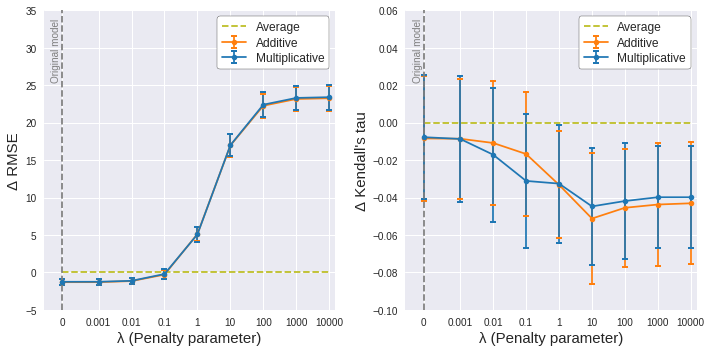

In [263]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
alpha = 2.262/sqrt(10)

errorbar_opts = {'markeredgewidth': 2, 'capsize': 3}
custom_opts = legend_opts.copy()
custom_opts['labelspacing'] = 0.3
custom_opts['loc'] = 'upper right'

ax1.errorbar(linear_lambda_df['lambda'], linear_lambda_df['rmse_diff_avg'], 
             yerr=alpha*linear_lambda_df['rmse_diff_std'],
           fmt='.-', color='tab:orange', label='Additive', **errorbar_opts)
ax1.errorbar(log_linear_lambda_df['lambda'], log_linear_lambda_df['rmse_diff_avg'], 
             yerr=alpha*log_linear_lambda_df['rmse_diff_std'],
           fmt='.-', color='tab:blue', label='Multiplicative', **errorbar_opts)

ax1.hlines(0, 0, 10000, linestyles='--', color='tab:olive', label='Average')
ax1.axvline(0, ls='--', color='tab:gray')
ax1.text(-0.0003, 34, s='Original model', verticalalignment='top', rotation=90, fontsize=10, color='tab:gray')
ax1.legend(**custom_opts)

ax1.set_xlabel('λ (Penalty parameter)', fontsize=15)
ax1.set_xscale('symlog', linthreshx=0.001)
ax1.set_xlim(-0.0005, 15000)
ax1.set_xticklabels(lambda_values)

ax1.set_ylim(-5, 35)
ax1.set_ylabel('Δ RMSE', fontsize=15)

ax2.errorbar(linear_lambda_df['lambda'], linear_lambda_df['tau_diff_avg'], 
             yerr=alpha*linear_lambda_df['tau_diff_std'],
           fmt='.-', color='tab:orange', label='Additive', **errorbar_opts)
ax2.errorbar(log_linear_lambda_df['lambda'], log_linear_lambda_df['tau_diff_avg'], 
             yerr=alpha*log_linear_lambda_df['tau_diff_std'],
           fmt='.-', color='tab:blue', label='Multiplicative', **errorbar_opts)

ax2.hlines(0, 0, 10000, linestyles='--', color='tab:olive', label='Average')
ax2.text(-0.0003, 0.06-0.16*1/40, s='Original model', verticalalignment='top', rotation=90, fontsize=10, color='tab:gray')
ax2.axvline(0, ls='--', color='tab:gray')


ax2_opts = legend_opts.copy()
ax2_opts['labelspacing'] = 0.3
ax2.legend(**custom_opts)

ax2.set_xscale('symlog', linthreshx=0.001)
ax2.set_xlim(-0.0005, 15000)
ax2.set_xticklabels(lambda_values)
ax2.set_xlabel('λ (Penalty parameter)', fontsize=15)
ax2.set_ylim(-0.10, 0.06)
ax2.set_ylabel("Δ Kendall's tau", fontsize=15)

plt.tight_layout()
plt.show()

fig.savefig('viz/diff_rmse_tau_vs_lambda.png')

Compare un-penalized models to average score model

In [154]:
rmses_df = pd.concat([avg_train_eval['rmse'], linear_train_eval['rmse'], loglinear_train_eval['rmse']], axis=1,
                    keys=['avg', 'linear', 'loglinear'])
taus_df = pd.concat([avg_train_eval['tau'], linear_train_eval['tau'], loglinear_train_eval['tau']], axis=1,
                   keys=['avg', 'linear', 'loglinear'])

In [155]:
rmses_df

,avg,linear,loglinear
0,10.357050,8.555327,8.649373
1,9.749220,7.883763,7.932804
2,8.151442,7.578146,7.651527
3,8.557905,8.110917,8.188401
4,11.139947,9.798364,9.785044
5,9.424702,8.144647,8.321286
6,9.965307,9.047367,8.987620
7,10.563519,8.781486,8.813433
8,12.694622,11.053367,11.073864
9,10.271547,8.838700,8.881273


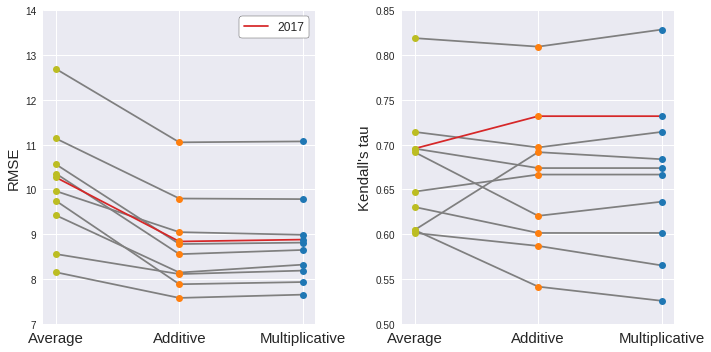

In [156]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
custom_opts = legend_opts.copy()
custom_opts['loc'] = 'upper right'

for i, row in rmses_df.iterrows():
    if i == 9:
        line_2017 = ax1.plot(range(3), row, color='tab:red')
    else:
        ax1.plot(range(3), row, color='tab:gray')
ax1.plot([0]*len(rmses_df), rmses_df['avg'], 'o', color='tab:olive')
ax1.plot([1]*len(rmses_df), rmses_df['linear'], 'o', color='tab:orange')
ax1.plot([2]*len(rmses_df), rmses_df['loglinear'], 'o', color='tab:blue')
ax1.legend(line_2017, ['2017'], **custom_opts)


ax1.set_xticks(range(3))
ax1.set_xticklabels(['Average', 'Additive', 'Multiplicative'], fontsize=15)
ax1.set_ylabel('RMSE', fontsize=15)
ax1.set_ylim(7, 14)

for i, row in taus_df.iterrows():
    if i == 9:
        line_2017 = ax2.plot(range(3), row, color='tab:red')
    else:
        ax2.plot(range(3), row, color='tab:gray')
ax2.plot([0]*len(taus_df), taus_df['avg'], 'o', color='tab:olive')
ax2.plot([1]*len(taus_df), taus_df['linear'], 'o', color='tab:orange')
ax2.plot([2]*len(taus_df), taus_df['loglinear'], 'o', color='tab:blue')

ax2.set_xticks(range(3))
ax2.set_xticklabels(['Average', 'Additive', 'Multiplicative'], fontsize=15)
ax2.set_ylabel("Kendall's tau", fontsize=15)
ax2.set_ylim(0.5, 0.85)

plt.tight_layout()
plt.show()

# fig.savefig('viz/avg_add_mul_unpenalized_10_years.png')

Final report

All 10 years in training set

In [265]:
avg = AverageScore()
avg_train_eval = avg.evaluate_over_years(train_years, season_train, world_train)
avg_train_eval

,year,rmse,tau,conc,pairs
0,2005,10.357050,0.647619,173,210
1,2006,9.749220,0.691700,214,253
2,2007,8.151442,0.630435,225,276
3,2009,8.557905,0.601449,221,276
4,2010,11.139947,0.714286,198,231
5,2012,9.424702,0.604743,203,253
6,2013,9.965307,0.604743,203,253
7,2014,10.563519,0.819048,191,210
8,2016,12.694622,0.695652,234,276
9,2017,10.271547,0.695652,234,276


In [268]:
linear = Linear(lambda_reg=0)
linear_train_eval = linear.evaluate_over_years(train_years, season_train, world_train)
linear_train_eval

,year,rmse,tau,conc,pairs
0,2005,8.555327,0.666667,175,210
1,2006,7.883763,0.620553,205,253
2,2007,7.578146,0.601449,221,276
3,2009,8.110917,0.586957,219,276
4,2010,9.798364,0.696970,196,231
5,2012,8.144647,0.541502,195,253
6,2013,9.047367,0.691700,214,253
7,2014,8.781486,0.809524,190,210
8,2016,11.053367,0.673913,231,276
9,2017,8.838700,0.731884,239,276


In [269]:
loglinear = LogLinear(lambda_reg=0)
loglinear_train_eval = loglinear.evaluate_over_years(train_years, season_train, world_train)
loglinear_train_eval

,year,rmse,tau,conc,pairs
0,2005,8.649373,0.666667,175,210
1,2006,7.932804,0.636364,207,253
2,2007,7.651527,0.601449,221,276
3,2009,8.188401,0.565217,216,276
4,2010,9.785044,0.714286,198,231
5,2012,8.321286,0.525692,193,253
6,2013,8.987620,0.683794,213,253
7,2014,8.813433,0.828571,192,210
8,2016,11.073864,0.673913,231,276
9,2017,8.881273,0.731884,239,276


In [270]:
linear_rmse_diffs = linear_train_eval['rmse'] - avg_train_eval['rmse']
linear_tau_diffs = linear_train_eval['tau'] - avg_train_eval['tau']

In [271]:
[linear_rmse_diffs.mean(),
linear_rmse_diffs.mean() - alpha * linear_rmse_diffs.std(),
linear_rmse_diffs.mean() + alpha * linear_rmse_diffs.std()]

[-1.3083179087964896, -1.6731370023931826, -0.9434988151997965]

In [272]:
[linear_tau_diffs.mean(),
linear_tau_diffs.mean() - alpha * linear_tau_diffs.std(),
linear_tau_diffs.mean() + alpha * linear_tau_diffs.std()]

[-0.008420854507811016, -0.04171868667978176, 0.02487697766415973]

In [273]:
loglinear_rmse_diffs = loglinear_train_eval['rmse'] - avg_train_eval['rmse']
loglinear_tau_diffs = loglinear_train_eval['tau'] - avg_train_eval['tau']

In [274]:
[loglinear_rmse_diffs.mean(),
loglinear_rmse_diffs.mean() - alpha * loglinear_rmse_diffs.std(),
loglinear_rmse_diffs.mean() + alpha * loglinear_rmse_diffs.std()]

[-1.259063741118085, -1.627000695612883, -0.8911267866232869]

In [275]:
[loglinear_tau_diffs.mean(),
 loglinear_tau_diffs.mean() - alpha * loglinear_tau_diffs.std(),
 loglinear_tau_diffs.mean() + alpha * loglinear_tau_diffs.std()]

[-0.007748917748917739, -0.04091773475695804, 0.025419899259122563]

# Do the same for female skaters

In [276]:
fseason_train, fworld_train, fseason_test, fworld_test = train_test_split(female_scores, train_years, test_years)
fseason_train.shape, fworld_train.shape, fseason_test.shape, fworld_test.shape

((1220, 4), (239, 4), (507, 4), (95, 4))

In [277]:
favg = AverageScore()
favg_train_eval = favg.evaluate_over_years(train_years, fseason_train, fworld_train)
favg_train_eval

,year,rmse,tau,conc,pairs
0,2005,7.565816,0.590476,167,210
1,2006,7.742614,0.593074,184,231
2,2007,7.169302,0.710145,236,276
3,2009,5.972928,0.683794,213,253
4,2010,9.310778,0.509881,191,253
5,2012,6.737205,0.523810,176,231
6,2013,5.924964,0.588933,201,253
7,2014,8.373916,0.722944,199,231
8,2016,6.556561,0.731884,239,276
9,2017,6.609788,0.579710,218,276


In [278]:
flinear = Linear(lambda_reg=0)
flinear_train_eval = flinear.evaluate_over_years(train_years, fseason_train, fworld_train)
flinear_train_eval

,year,rmse,tau,conc,pairs
0,2005,6.376851,0.561905,164,210
1,2006,6.582065,0.610390,186,231
2,2007,6.428264,0.739130,240,276
3,2009,5.342399,0.683794,213,253
4,2010,6.983639,0.486166,188,253
5,2012,5.670575,0.471861,170,231
6,2013,5.036148,0.596838,202,253
7,2014,6.274096,0.722944,199,231
8,2016,6.293459,0.731884,239,276
9,2017,6.129382,0.623188,224,276


In [279]:
floglinear = LogLinear(lambda_reg=0)
floglinear_train_eval = floglinear.evaluate_over_years(train_years, fseason_train, fworld_train)
floglinear_train_eval

,year,rmse,tau,conc,pairs
0,2005,6.386825,0.561905,164,210
1,2006,6.613729,0.610390,186,231
2,2007,6.467467,0.739130,240,276
3,2009,5.432953,0.675889,212,253
4,2010,6.845203,0.494071,189,253
5,2012,5.659339,0.480519,171,231
6,2013,5.004460,0.604743,203,253
7,2014,6.328152,0.714286,198,231
8,2016,6.313307,0.739130,240,276
9,2017,6.172280,0.623188,224,276


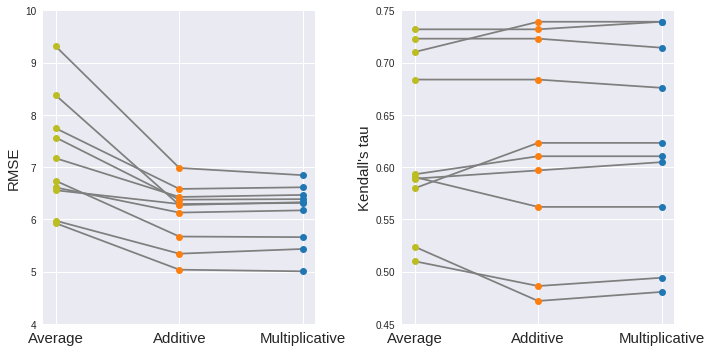

In [280]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
custom_opts = legend_opts.copy()
custom_opts['loc'] = 'upper right'

for i, row in frmses_df.iterrows():
    ax1.plot(range(3), row, color='tab:gray')
ax1.plot([0]*len(frmses_df), frmses_df['avg'], 'o', color='tab:olive')
ax1.plot([1]*len(frmses_df), frmses_df['linear'], 'o', color='tab:orange')
ax1.plot([2]*len(frmses_df), frmses_df['loglinear'], 'o', color='tab:blue')

ax1.set_xticks(range(3))
ax1.set_xticklabels(['Average', 'Additive', 'Multiplicative'], fontsize=15)
ax1.set_ylabel('RMSE', fontsize=15)
ax1.set_ylim(4, 10)

for i, row in ftaus_df.iterrows():
    ax2.plot(range(3), row, color='tab:gray')
ax2.plot([0]*len(ftaus_df), ftaus_df['avg'], 'o', color='tab:olive')
ax2.plot([1]*len(ftaus_df), ftaus_df['linear'], 'o', color='tab:orange')
ax2.plot([2]*len(ftaus_df), ftaus_df['loglinear'], 'o', color='tab:blue')

ax2.set_xticks(range(3))
ax2.set_xticklabels(['Average', 'Additive', 'Multiplicative'], fontsize=15)
ax2.set_ylabel("Kendall's tau", fontsize=15)
ax2.set_ylim(0.45, 0.75)

plt.tight_layout()
plt.show()

fig.savefig('viz/favg_add_mul_unpenalized_10_years.png')

In [281]:
flinear_rmse_diffs = flinear_train_eval['rmse'] - favg_train_eval['rmse']
flinear_tau_diffs = flinear_train_eval['tau'] - favg_train_eval['tau']

In [282]:
frmse_diffs.mean(), frmse_diffs.mean() - alpha * frmse_diffs.std(), frmse_diffs.mean() + alpha * frmse_diffs.std()

(-1.0846994716567866, -1.5612140068433635, -0.6081849364702097)

In [283]:
ftau_diffs.mean(), ftau_diffs.mean() - alpha * ftau_diffs.std(), ftau_diffs.mean() + alpha * ftau_diffs.std()

(-0.0006549971767363328, -0.020838989621060844, 0.01952899526758818)

In [284]:
floglinear_rmse_diffs = floglinear_train_eval['rmse'] - favg_train_eval['rmse']
floglinear_tau_diffs = floglinear_train_eval['tau'] - favg_train_eval['tau']

In [285]:
floglinear_rmse_diffs.mean(), floglinear_rmse_diffs.mean() - alpha * floglinear_rmse_diffs.std(), floglinear_rmse_diffs.mean() + alpha * floglinear_rmse_diffs.std()

(-1.074015944566933, -1.5762823070328977, -0.5717495821009684)

In [286]:
floglinear_tau_diffs.mean(), floglinear_tau_diffs.mean() - alpha * floglinear_tau_diffs.std(), floglinear_tau_diffs.mean() + alpha * floglinear_tau_diffs.std()

(0.0008601543384151644, -0.018219488982730885, 0.019939797659561217)